In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Input, LSTM, Dropout

In [ ]:
def load_activity_map():
    map = {}
    map[0] = 'transient'
    map[1] = 'lying'
    map[2] = 'sitting'
    map[3] = 'standing'
    map[4] = 'walking'
    map[5] = 'running'
    map[6] = 'cycling'
    map[7] = 'Nordic_walking'
    map[8] = 'watching_TV'
    map[9] = 'computer_work'
    map[10] = 'car driving'
    map[11] = 'ascending_stairs'
    map[12] = 'descending_stairs'
    map[13] = 'vacuum_cleaning'
    map[14] = 'ironing'
    map[15] = 'folding_laundry'
    map[16] = 'house_cleaning'
    map[17] = 'playing_soccer'
    map[18] = 'rope_jumping'
    return map

If you have the dataset in Google drive, use this

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If you dont, use this

In [ ]:
!wget https://archive.ics.uci.edu/static/public/231/pamap2+physical+activity+monitoring.zip

--2023-11-21 18:36:07--  https://archive.ics.uci.edu/static/public/231/pamap2+physical+activity+monitoring.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘pamap2+physical+activity+monitoring.zip’

pamap2+physical+act     [          <=>       ] 656.34M  36.8MB/s    in 12s     

2023-11-21 18:36:19 (57.0 MB/s) - ‘pamap2+physical+activity+monitoring.zip’ saved [688226940]



In [ ]:
!unzip pamap2+physical+activity+monitoring.zip

Archive:  pamap2+physical+activity+monitoring.zip
replace PAMAP2_Dataset.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip /content/PAMAP2_Dataset.zip

unzip:  cannot find or open /content/PAMAP2_Dataset.zip, /content/PAMAP2_Dataset.zip.zip or /content/PAMAP2_Dataset.zip.ZIP.


No need to run this below cell

In [ ]:
!cp -r /content/PAMAP2_Dataset /content/drive/MyDrive

Start from this now

In [ ]:
def generate_three_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    return [x,y,z]


def generate_four_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    w = name +'_w'
    return [x,y,z,w]

def generate_cols_IMU(name):
    # temp
    temp = name+'_temperature'
    output = [temp]
    # acceleration 16
    acceleration16 = name+'_3D_acceleration_16'
    acceleration16 = generate_three_IMU(acceleration16)
    output.extend(acceleration16)
    # acceleration 6
    acceleration6 = name+'_3D_acceleration_6'
    acceleration6 = generate_three_IMU(acceleration6)
    output.extend(acceleration6)
    # gyroscope
    gyroscope = name+'_3D_gyroscope'
    gyroscope = generate_three_IMU(gyroscope)
    output.extend(gyroscope)
    # magnometer
    magnometer = name+'_3D_magnetometer'
    magnometer = generate_three_IMU(magnometer)
    output.extend(magnometer)
    # oreintation
    oreintation = name+'_4D_orientation'
    oreintation = generate_four_IMU(oreintation)
    output.extend(oreintation)
    return output

def load_IMU():
    output = ['time_stamp','activity_id', 'heart_rate']
    hand = 'hand'
    hand = generate_cols_IMU(hand)
    output.extend(hand)
    chest = 'chest'
    chest = generate_cols_IMU(chest)
    output.extend(chest)
    ankle = 'ankle'
    ankle = generate_cols_IMU(ankle)
    output.extend(ankle)
    return output

def load_subjects(root='/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject'):
    output = pd.DataFrame()
    cols = load_IMU()

    for i in range(101,110):
        path = root + str(i) +'.dat'
        subject = pd.read_table(path, header=None, sep='\s+')
        subject.columns = cols
        subject['id'] = i
        output = output.append(subject, ignore_index=True)
    output.reset_index(drop=True, inplace=True)
    return output

data = load_subjects()
data

<ipython-input-4-a14e26637b6a>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(subject, ignore_index=True)
<ipython-input-4-a14e26637b6a>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(subject, ignore_index=True)
<ipython-input-4-a14e26637b6a>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(subject, ignore_index=True)
<ipython-input-4-a14e26637b6a>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(subject, ignore_index=True)
<ipython-input-4-a14e26637b6a>:63: FutureWarning: The frame.append method is deprecated and will be removed from pan

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
0,8.38,0,104.0,30.0000,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.95990,-58.143800,1.000000,0.000000,0.000000,0.000000,101
1,8.39,0,NaN,30.0000,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.89190,-58.525300,1.000000,0.000000,0.000000,0.000000,101
2,8.40,0,NaN,30.0000,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.41380,-58.399900,1.000000,0.000000,0.000000,0.000000,101
3,8.41,0,NaN,30.0000,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.76350,-58.395600,1.000000,0.000000,0.000000,0.000000,101
4,8.42,0,NaN,30.0000,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.38790,-58.269400,1.000000,0.000000,0.000000,0.000000,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872528,100.19,0,NaN,25.1875,-4.71493,10.22250,4.66893,-5.04654,9.94944,4.50736,...,-0.062676,-0.127084,-46.5153,3.58240,-0.035995,0.598531,0.033615,0.799791,-0.031075,109
2872529,100.20,0,NaN,25.1875,-4.95932,10.37130,4.12594,-4.96890,10.29620,4.43102,...,-0.027006,-0.089808,-45.7474,3.54453,0.108583,0.598428,0.033012,0.799933,-0.030018,109
2872530,100.21,0,NaN,25.1875,-4.93997,9.83615,3.70468,-5.04613,10.35690,4.14405,...,-0.038024,-0.064709,-46.3997,4.22078,0.105504,0.598233,0.033172,0.800095,-0.029416,109
2872531,100.22,0,NaN,25.1875,-4.64941,9.11129,3.51904,-5.06854,9.75268,3.87359,...,-0.025796,-0.064357,-46.5282,4.48593,0.530240,0.598116,0.033427,0.800180,-0.029208,109


#Statistical Analysis of NULL values in dataframe
(Checking if the missing values are random or dependent on some features)

#1. MAR (Missing at Random):
Missing at Random (MAR) characterizes a systematic pattern of missing data where the likelihood of data being missing depends on the observed variables in a dataset.

**Checking for Missing at Random (MAR) without direct access to missing values is challenging because MAR is a concept related to the missing data mechanism, and it often relies on having some understanding of the reasons for missingness. If you don't have access to missing values or any additional information about why they are missing, it's difficult to directly test for MAR. However, you can still make certain assumptions and indirect assessments:**

And, as we dont have direct access to missing values, we will now switch to other approaches like MCAR to justify nature of missing values in our dataset.

#2. MCAR (Missing Completely at Random):

The code aims to assess whether the missing data in a DataFrame is distributed randomly and unrelated to both observed and unobserved data. If the missing data is MCAR, it means that the missingness is not systematic or influenced by any specific factors within the dataset. This is an important assumption in statistical analysis, as it allows for unbiased inferences.

**Test Used**

The chi-square test is a statistical test used to assess the independence of two categorical variables. In this case, it's applied to evaluate the independence between the presence or absence of missing data (binary variable) and the observed data in each column.
The null hypothesis (H0) of the chi-square test is that the missingness is independent of the observed data, i.e., the data is MCAR. The alternative hypothesis (H1) is that the missingness is not independent, indicating a pattern other than MCAR.

If the p-value (denoted as 'p' in the code) obtained from the chi-square test is less than 0.05 (a common significance level), the code prints "Missing data is not MCAR." This means that the missing data is not consistent with MCAR, and there is evidence to reject the null hypothesis.
Conversely, if the p-value is greater than or equal to 0.05, the code prints "Missing data is consistent with MCAR." This suggests that the missing data is random and unrelated to observed data, and there is insufficient evidence to reject the null hypothesis.

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# Assuming you have a DataFrame named 'data'
# Replace this with your actual DataFrame

# Define the target variable
target_variable = 'heart_rate'

# Initialize a dictionary to store the MCAR results for all variables
mcar_results = {}

# Loop through all columns as potential independent variables
for variable in data.columns:
    # Skip the target variable
    if variable == target_variable:
        continue

    # Create a contingency table directly without creating a new column
    contingency_table = pd.crosstab(data[variable].isnull(), data[target_variable].isnull())

    # Perform the chi-squared test
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Determine if the result is significant (p-value < 0.05)
    is_independent = p >= 0.05

    # Store the result in the dictionary
    mcar_results[variable] = {
        "Chi-squared statistic": chi2,
        "P-value": p,
        "Independent": is_independent
    }

# Print the MCAR results for each variable
for variable, result in mcar_results.items():
    print(f"Variable: {variable}")
    # print(f"Chi-squared statistic: {result['Chi-squared statistic']}")
    # print(f"P-value: {result['P-value']}")
    if result['Independent']:
        print(f"The missingness in '{target_variable}' is independent of {variable}")
    else:
        print(f"The missingness in '{target_variable}' is dependent on {variable}")
    print()


Variable: time_stamp
The missingness in 'heart_rate' is independent of time_stamp

Variable: activity_id
The missingness in 'heart_rate' is independent of activity_id

Variable: hand_temperature
The missingness in 'heart_rate' is independent of hand_temperature

Variable: hand_3D_acceleration_16_x
The missingness in 'heart_rate' is independent of hand_3D_acceleration_16_x

Variable: hand_3D_acceleration_16_y
The missingness in 'heart_rate' is independent of hand_3D_acceleration_16_y

Variable: hand_3D_acceleration_16_z
The missingness in 'heart_rate' is independent of hand_3D_acceleration_16_z

Variable: hand_3D_acceleration_6_x
The missingness in 'heart_rate' is independent of hand_3D_acceleration_6_x

Variable: hand_3D_acceleration_6_y
The missingness in 'heart_rate' is independent of hand_3D_acceleration_6_y

Variable: hand_3D_acceleration_6_z
The missingness in 'heart_rate' is independent of hand_3D_acceleration_6_z

Variable: hand_3D_gyroscope_x
The missingness in 'heart_rate' is 

When it's stated that **"data is consistent with MCAR," it signifies that the pattern of missing data in the dataset adheres to the principle of Missing Completely At Random (MCAR).**

In practical terms, this means that

1. The occurrence of missing values appears to be entirely random and unrelated to any observed or unobserved variables within the dataset.

2. There is no systematic bias or discernible pattern in the missingness, suggesting that the likelihood of data being missing doesn't depend on any specific characteristics or variables.

This random nature of missingness allows for conducting unbiased statistical analyses and drawing valid conclusions without the risk of introducing significant bias into the results.

**It implies that straightforward imputation methods, such as mean imputation or listwise deletion, can be safely applied because the missingness is independent of the values that are missing. Recognizing MCAR is a fundamental assumption in many statistical analyses, ensuring the integrity of research findings when dealing with missing data.**

Here, it is done for heart_rate, but can be done for all possible columns too.

**After careful observations to all possible values, missingess of all values in a column are independent of observed values in other columns of that dataframe**

#Interpolating NULL values

COUNT OF NULL VALUES IN DATAFRAME

In [ ]:
data.isna().sum()

time_stamp                          0
activity_id                         0
heart_rate                    2610265
hand_temperature                13141
hand_3D_acceleration_16_x       13141
hand_3D_acceleration_16_y       13141
hand_3D_acceleration_16_z       13141
hand_3D_acceleration_6_x        13141
hand_3D_acceleration_6_y        13141
hand_3D_acceleration_6_z        13141
hand_3D_gyroscope_x             13141
hand_3D_gyroscope_y             13141
hand_3D_gyroscope_z             13141
hand_3D_magnetometer_x          13141
hand_3D_magnetometer_y          13141
hand_3D_magnetometer_z          13141
hand_4D_orientation_x           13141
hand_4D_orientation_y           13141
hand_4D_orientation_z           13141
hand_4D_orientation_w           13141
chest_temperature                3563
chest_3D_acceleration_16_x       3563
chest_3D_acceleration_16_y       3563
chest_3D_acceleration_16_z       3563
chest_3D_acceleration_6_x        3563
chest_3D_acceleration_6_y        3563
chest_3D_acc

% OF NULL VALUES FOR EACH COLUMN IN DATAFRAME

In [ ]:
import pandas as pd

# Assuming you have a DataFrame named df
# Calculate the percentage of NaN values in each column
percentage_null = (data.isna().sum() / len(data)) * 100

# The percentage_null variable now contains the percentage of NaN values in each column
print(percentage_null)


time_stamp                     0.000000
activity_id                    0.000000
heart_rate                    90.869800
hand_temperature               0.457471
hand_3D_acceleration_16_x      0.457471
hand_3D_acceleration_16_y      0.457471
hand_3D_acceleration_16_z      0.457471
hand_3D_acceleration_6_x       0.457471
hand_3D_acceleration_6_y       0.457471
hand_3D_acceleration_6_z       0.457471
hand_3D_gyroscope_x            0.457471
hand_3D_gyroscope_y            0.457471
hand_3D_gyroscope_z            0.457471
hand_3D_magnetometer_x         0.457471
hand_3D_magnetometer_y         0.457471
hand_3D_magnetometer_z         0.457471
hand_4D_orientation_x          0.457471
hand_4D_orientation_y          0.457471
hand_4D_orientation_z          0.457471
hand_4D_orientation_w          0.457471
chest_temperature              0.124037
chest_3D_acceleration_16_x     0.124037
chest_3D_acceleration_16_y     0.124037
chest_3D_acceleration_16_z     0.124037
chest_3D_acceleration_6_x      0.124037



Even when facing a large number of missing values, it's crucial to handle them rather than remove them. This preserves valuable data, maintains the integrity of your analysis, and reduces potential bias, as missing data often carries valuable insights. By using appropriate imputation or interpolation techniques, you can make the most of your data and produce more comprehensive and reliable results, even in the presence of missing values.

We use interpolation or imputation instead of removing missing data to preserve valuable information, reduce bias, and maintain data integrity. Polynomial interpolation estimates values between known data points assuming a polynomial relationship. However, for missing value imputation, simpler methods are generally preferred as they work well for most datasets and avoid overfitting.

In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# Define a function for cubic (spline) interpolation
def interpolate_column(column):
    x = column.dropna().index
    y = column.dropna().values
    f = interp1d(x, y, kind='cubic', fill_value='extrapolate')
    return pd.Series(f(column.index))

# Apply cubic interpolation to each column in 'new_data'
for column in data.columns:
    data[column] = interpolate_column(data[column])

# Handling any remaining NaN values in 'new_data' using forward fill
data.fillna(method='ffill', inplace=True)


In [ ]:
import pandas as pd

# Assuming you have a DataFrame named df
# Calculate the percentage of NaN values in each column
percentage_null = (data.isna().sum() / len(data)) * 100

# The percentage_null variable now contains the percentage of NaN values in each column
print(percentage_null)


time_stamp                    0.0
activity_id                   0.0
heart_rate                    0.0
hand_temperature              0.0
hand_3D_acceleration_16_x     0.0
hand_3D_acceleration_16_y     0.0
hand_3D_acceleration_16_z     0.0
hand_3D_acceleration_6_x      0.0
hand_3D_acceleration_6_y      0.0
hand_3D_acceleration_6_z      0.0
hand_3D_gyroscope_x           0.0
hand_3D_gyroscope_y           0.0
hand_3D_gyroscope_z           0.0
hand_3D_magnetometer_x        0.0
hand_3D_magnetometer_y        0.0
hand_3D_magnetometer_z        0.0
hand_4D_orientation_x         0.0
hand_4D_orientation_y         0.0
hand_4D_orientation_z         0.0
hand_4D_orientation_w         0.0
chest_temperature             0.0
chest_3D_acceleration_16_x    0.0
chest_3D_acceleration_16_y    0.0
chest_3D_acceleration_16_z    0.0
chest_3D_acceleration_6_x     0.0
chest_3D_acceleration_6_y     0.0
chest_3D_acceleration_6_z     0.0
chest_3D_gyroscope_x          0.0
chest_3D_gyroscope_y          0.0
chest_3D_gyros

#Further Data Analysis

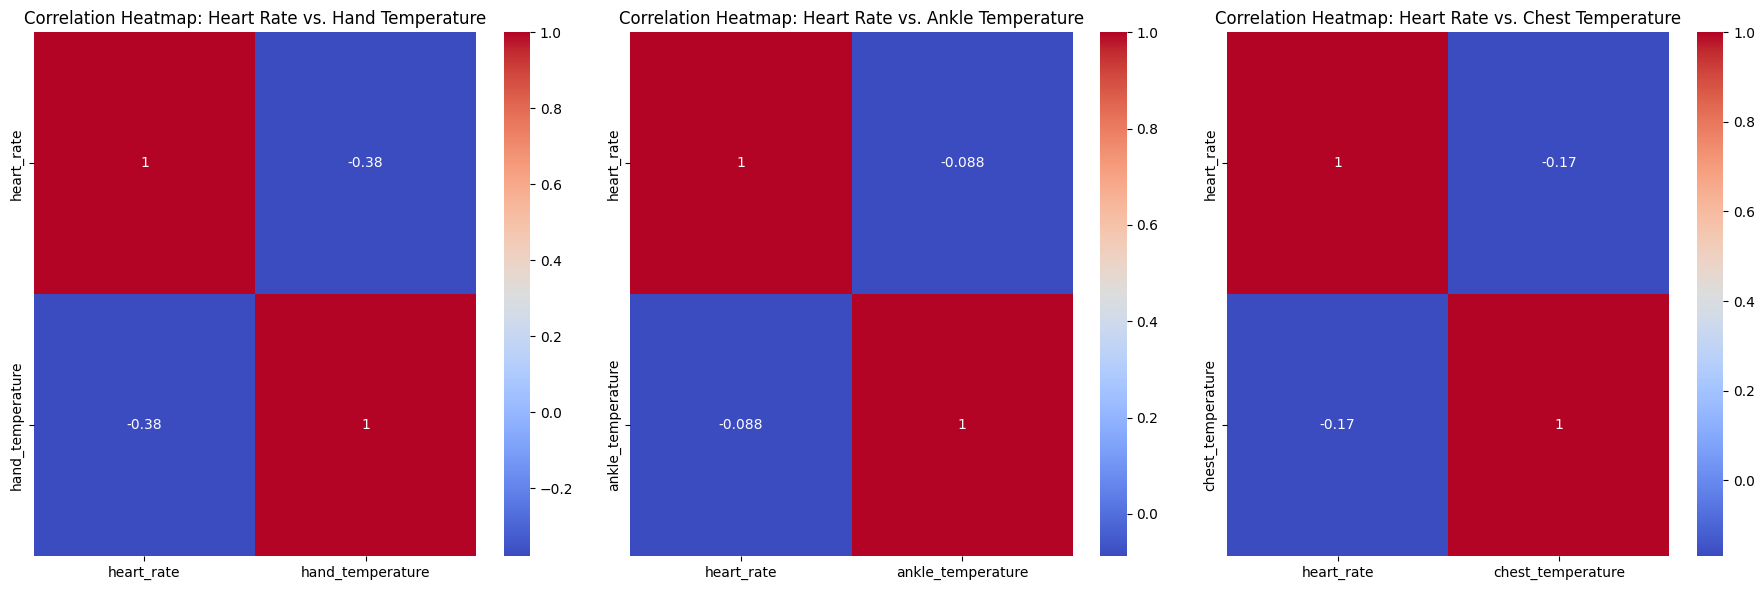

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'data'
# Select the relevant columns for each pair
columns_hand = ['heart_rate', 'hand_temperature']
columns_ankle = ['heart_rate', 'ankle_temperature']
columns_chest = ['heart_rate', 'chest_temperature']

# Compute the correlation matrices for each pair
correlation_matrix_hand = data[columns_hand].corr()
correlation_matrix_ankle = data[columns_ankle].corr()
correlation_matrix_chest = data[columns_chest].corr()

# Create a 1x3 grid for subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Set plot titles
titles = ["Hand Temperature", "Ankle Temperature", "Chest Temperature"]

# Create heatmaps and arrange them in the grid
heatmaps = [
    sns.heatmap(correlation_matrix_hand, annot=True, cmap="coolwarm", ax=axes[0]),
    sns.heatmap(correlation_matrix_ankle, annot=True, cmap="coolwarm", ax=axes[1]),
    sns.heatmap(correlation_matrix_chest, annot=True, cmap="coolwarm", ax=axes[2])
]

# Set subplot titles
for i, ax in enumerate(axes):
    ax.set_title(f"Correlation Heatmap: Heart Rate vs. {titles[i]}")

# Adjust spacing
plt.tight_layout()

# Show the combined plot
plt.show()


#Dealing with NULL values in dataset
(As of now, filling them with mean values to work around with dataset)

In [ ]:
def fix_data(data):
    data = data.drop(data[data['activity_id']==0].index)
    data = data.interpolate()
    # fill all the NaN values in a coulmn with the mean values of the column
    for colName in data.columns:
        data[colName] = data[colName].fillna(data[colName].mean())
    activity_mean = data.groupby(['activity_id']).mean().reset_index()
    return data

data = fix_data(data)

#Exploratory DataSet from Documentation:

In [ ]:
data.describe()

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
count,2.010718e+06,2.010718e+06,2.010718e+06,2.010718e+06,2.010718e+06,2.010718e+06,2.010718e+06,2.010718e+06,2.010718e+06,2.010718e+06,...,2.010718e+06,2.010718e+06,2.010718e+06,2.010718e+06,2.010718e+06,2.010718e+06,2.010718e+06,2.010718e+06,2.010718e+06,2.010718e+06
mean,1.712257e+03,7.809132e+00,1.077393e+02,3.274382e+01,-4.925200e+00,3.615228e+00,3.558054e+00,-4.857335e+00,3.604571e+00,3.742556e+00,...,-3.537523e-02,6.533943e-03,-3.162532e+01,1.381785e+00,1.721071e+01,3.831331e-01,-5.461785e-03,3.035512e-01,-5.321027e-02,1.045665e+02
std,1.093894e+03,6.242679e+00,2.700348e+01,1.804302e+00,6.203539e+00,6.829188e+00,3.946754e+00,6.209971e+00,6.531515e+00,3.933833e+00,...,6.280862e-01,1.979341e+00,1.832678e+01,2.172824e+01,1.978924e+01,3.036268e-01,5.716665e-01,3.313739e-01,4.789847e-01,2.335032e+00
min,5.700000e+00,-4.440892e-16,5.689235e+01,2.487500e+01,-1.453670e+02,-1.043010e+02,-1.014520e+02,-6.266497e+01,-6.184170e+01,-6.193470e+01,...,-1.812690e+01,-1.401960e+01,-1.728650e+02,-1.379080e+02,-1.027160e+02,-4.293933e-03,-1.609862e+00,-1.196679e+00,-1.193673e+00,1.010000e+02
25%,7.514600e+02,3.000000e+00,8.600672e+01,3.162500e+01,-8.969080e+00,1.120315e+00,1.128880e+00,-8.864890e+00,1.120975e+00,1.333530e+00,...,-9.568813e-02,-3.893741e-01,-4.173270e+01,-1.242780e+01,3.715718e+00,1.432630e-01,-6.100728e-01,5.610323e-03,-5.325290e-01,1.020000e+02
50%,1.500610e+03,6.000000e+00,1.050000e+02,3.312500e+01,-5.439960e+00,3.554705e+00,3.379010e+00,-5.368280e+00,3.593240e+00,3.608080e+00,...,-4.020660e-03,-1.917610e-03,-3.392870e+01,8.372270e-01,1.871470e+01,2.872545e-01,0.000000e+00,3.056685e-01,0.000000e+00,1.050000e+02
75%,2.665750e+03,1.300000e+01,1.240000e+02,3.406250e+01,-9.124158e-01,6.506890e+00,6.487130e+00,-8.622087e-01,6.514600e+00,6.739020e+00,...,1.044098e-01,7.955608e-02,-1.803950e+01,1.774150e+01,3.119458e+01,5.624290e-01,6.184790e-01,5.976987e-01,4.417317e-01,1.070000e+02
max,4.251360e+03,2.400000e+01,2.021077e+02,3.550000e+01,6.285960e+01,1.556990e+02,1.577600e+02,5.282140e+01,6.805576e+01,6.192340e+01,...,1.358820e+01,1.652880e+01,9.155160e+01,9.424780e+01,1.469000e+02,1.000000e+00,2.642665e+00,1.223159e+00,1.932475e+00,1.090000e+02


#Observation
Timestamp: The dataset contains a large number of observations, with a minimum timestamp of 31 seconds and a maximum timestamp of 4,245,680 seconds. This wide range suggests that the data spans a significant period of time.

Activity ID: There are 24 different activity IDs recorded in the dataset, indicating that it covers a variety of physical activities or actions.

Heart Rate: The heart rate data shows that the average heart rate across all observations is approximately 107.5 beats per minute (bpm), with a standard deviation of around 26.99 bpm. This information can be valuable for analyzing heart rate variations during different activities or over time.

Hand Temperature: The hand temperature data has an average of approximately 32.75 degrees Celsius, with a relatively low standard deviation of about 1.79 degrees Celsius. This suggests that hand temperature remains relatively stable during the recorded activities.


In [ ]:
print('Size of the data: ', data.size)
print('Shape of the data: ', data.shape)
print('Number of columns in the data: ', len(data.columns))
result_id = data.groupby(['id']).mean().reset_index()
print('Number of uniqe ids in the data: ', len(result_id))
result_act = data.groupby(['activity_id']).mean().reset_index()
print('Numbe of uniqe activitys in the data: ',len(result_act))

Size of the data:  110589490
Shape of the data:  (2010718, 55)
Number of columns in the data:  55
Number of uniqe ids in the data:  23
Numbe of uniqe activitys in the data:  6482


#Balance Analysis


In [ ]:
data['id'] = data['id'].astype(int)
data['activity_id'] = data['activity_id'].astype(int)

In [ ]:
display(data)

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
2387,32.25,0,98.0,30.3125,1.29999,9.39947,-1.43466,1.40492,10.24500,-1.13247,...,-0.028037,-0.018546,-61.0992,-37.63280,-58.625400,1.000000,0.000000,0.000000,0.000000,101
2391,32.29,0,98.0,30.3125,1.52029,10.38080,-1.81955,1.62355,10.16710,-1.94796,...,-0.020675,-0.002892,-60.4215,-37.66480,-58.012400,1.000000,0.000000,0.000000,0.000000,101
2397,32.35,0,98.0,30.3125,1.57689,9.95884,-2.27913,1.48057,9.54870,-2.20317,...,-0.005668,0.010624,-61.6563,-37.72680,-58.374300,1.000000,0.000000,0.000000,0.000000,101
2398,32.36,0,98.0,30.3125,1.58249,10.75560,-2.28173,1.49958,10.03180,-2.21935,...,-0.017329,0.031762,-60.8755,-37.53200,-58.502400,1.000000,0.000000,0.000000,0.000000,101
2399,32.37,0,98.0,30.3750,1.60575,11.21590,-1.70562,1.50668,10.74170,-2.08501,...,-0.017381,-0.006806,-61.1069,-37.29680,-58.993100,1.000000,0.000000,0.000000,0.000000,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872526,100.17,0,161.0,25.1875,-4.92285,9.42385,4.28364,-4.95310,8.72528,4.29854,...,0.009088,-0.150870,-46.0219,4.45943,0.106556,0.598612,0.034964,0.799558,-0.033895,109
2872527,100.18,0,161.0,25.1875,-4.99389,9.88004,4.31952,-5.02286,9.36011,4.32742,...,0.011414,-0.139014,-46.0153,4.07245,-0.034804,0.598686,0.034488,0.799575,-0.032635,109
2872528,100.19,0,161.0,25.1875,-4.71493,10.22250,4.66893,-5.04654,9.94944,4.50736,...,-0.062676,-0.127084,-46.5153,3.58240,-0.035995,0.598531,0.033615,0.799791,-0.031075,109
2872529,100.20,0,161.0,25.1875,-4.95932,10.37130,4.12594,-4.96890,10.29620,4.43102,...,-0.027006,-0.089808,-45.7474,3.54453,0.108583,0.598428,0.033012,0.799933,-0.030018,109


<ipython-input-16-acb94ff542fb>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  a = ax.set_xticklabels(pd[column_b])


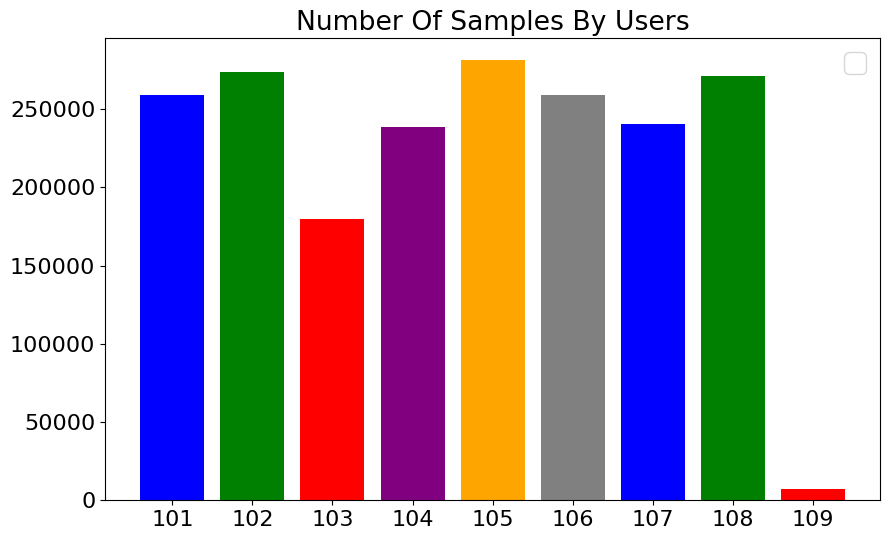

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def pd_fast_plot(pd, column_a, column_b, title, figsize=(10, 6), colors=None):
    plt.rcParams.update({'font.size': 16})
    size = range(len(pd))
    f, ax = plt.subplots(figsize=figsize)

    # Use custom colors if provided, or use a default colormap
    if colors is None:
        colors = plt.cm.Paired(size)

    plt.bar(size, pd[column_a], color=colors)
    a = ax.set_xticklabels(pd[column_b])
    b = ax.legend(fontsize=20)
    c = ax.set_xticks(np.arange(len(pd)))
    d = ax.set_title(title)
    plt.show()

# Example usage with custom colors
sampels = data.groupby(['id']).count().reset_index()
sampels_to_subject = pd.DataFrame()
sampels_to_subject['id'] = sampels['id']
sampels_to_subject['sampels'] = sampels['time_stamp']

# Sort the DataFrame by 'id' before plotting
sampels_to_subject = sampels_to_subject.sort_values(by=['id'])

# Define custom colors (e.g., a list of color names)
custom_colors = ['blue', 'green', 'red', 'purple', 'orange', 'gray']

# Call the function with custom colors
pd_fast_plot(sampels_to_subject, 'sampels', 'id', 'Number Of Samples By Users', colors=custom_colors)


#About Graph
X-Axis (Horizontal Axis): The x-axis represents the users or individuals for whom data has been collected. Each bar on the x-axis corresponds to a specific user.

Y-Axis (Vertical Axis): The y-axis represents the number of samples collected by each user. The height of each bar on the y-axis corresponds to the count or quantity of samples associated with the respective user on the x-axis.

<ipython-input-16-acb94ff542fb>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  a = ax.set_xticklabels(pd[column_b])


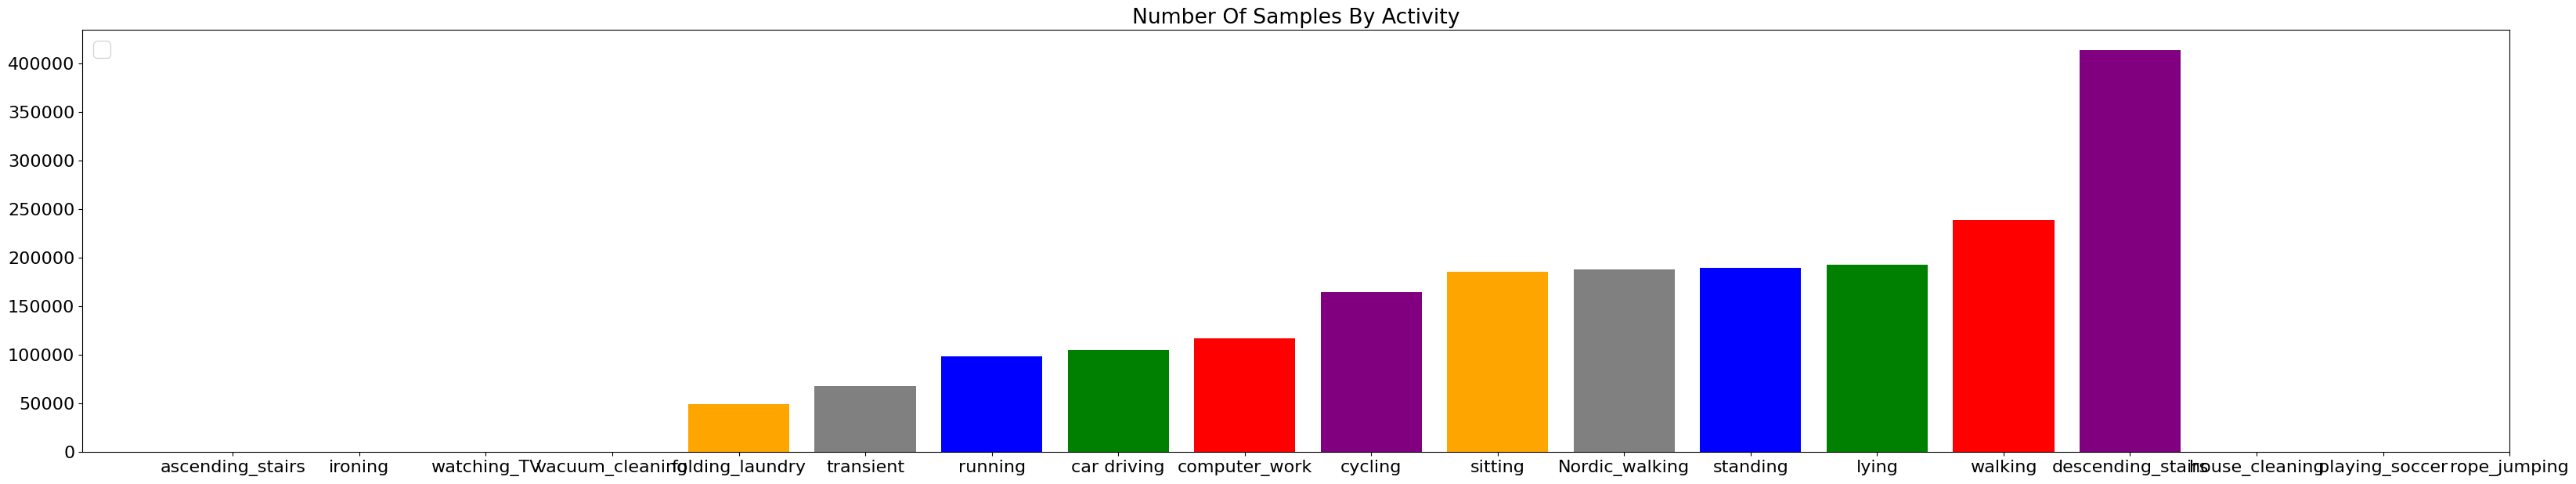

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the pd_fast_plot function as shown previously

# Example usage with custom colors
map_ac = load_activity_map()
sampels = data.groupby(['activity_id']).count().reset_index()
sampels_to_subject = pd.DataFrame()
sampels_to_subject['activity'] = [map_ac[x] for x in range(19)]
sampels_to_subject['sampels'] = sampels['time_stamp']
sampels_to_subject = sampels_to_subject.sort_values(by=['sampels'])

# Define custom colors (e.g., a list of color names)
custom_colors = ['blue', 'green', 'red', 'purple', 'orange', 'gray']

# Call the function with custom colors
pd_fast_plot(
    sampels_to_subject,
    'sampels',
    'activity',
    'Number Of Samples By Activity',
    figsize=(40, 7),
    colors=custom_colors
)


#About Graph

X-Axis (Horizontal Axis): The x-axis represents different activities or categories. Each activity is labeled on the x-axis.

Y-Axis (Vertical Axis): The y-axis represents the number of samples recorded for each activity. The height of each bar on the y-axis corresponds to the count or quantity of samples collected for a specific activity.

#Final Observation

We can see the data isn't balanced:

Subject 109 as less sampels then all others subjects.

rope_jumping activity as less samples then other activities

#Heart Rate analysis

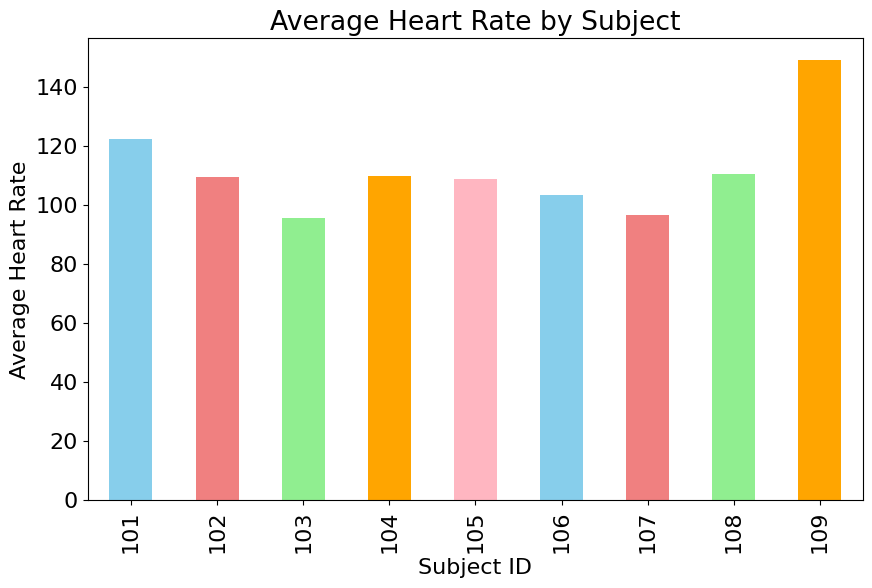

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
# Convert 'heart_rate' column to numeric
data['heart_rate'] = pd.to_numeric(data['heart_rate'], errors='coerce')

# Group by 'id' and calculate the average heart rate for each subject
average_heart_rate_by_subject = data.groupby('id')['heart_rate'].mean()

# Define custom colors for the bars
custom_colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange', 'lightpink']

# Plot the bar graph with custom colors
plt.figure(figsize=(10, 6))
average_heart_rate_by_subject.plot(kind='bar', color=custom_colors)
plt.title('Average Heart Rate by Subject')
plt.xlabel('Subject ID')
plt.ylabel('Average Heart Rate')
plt.show()


#Temperature Analysis

<Figure size 1000x600 with 0 Axes>

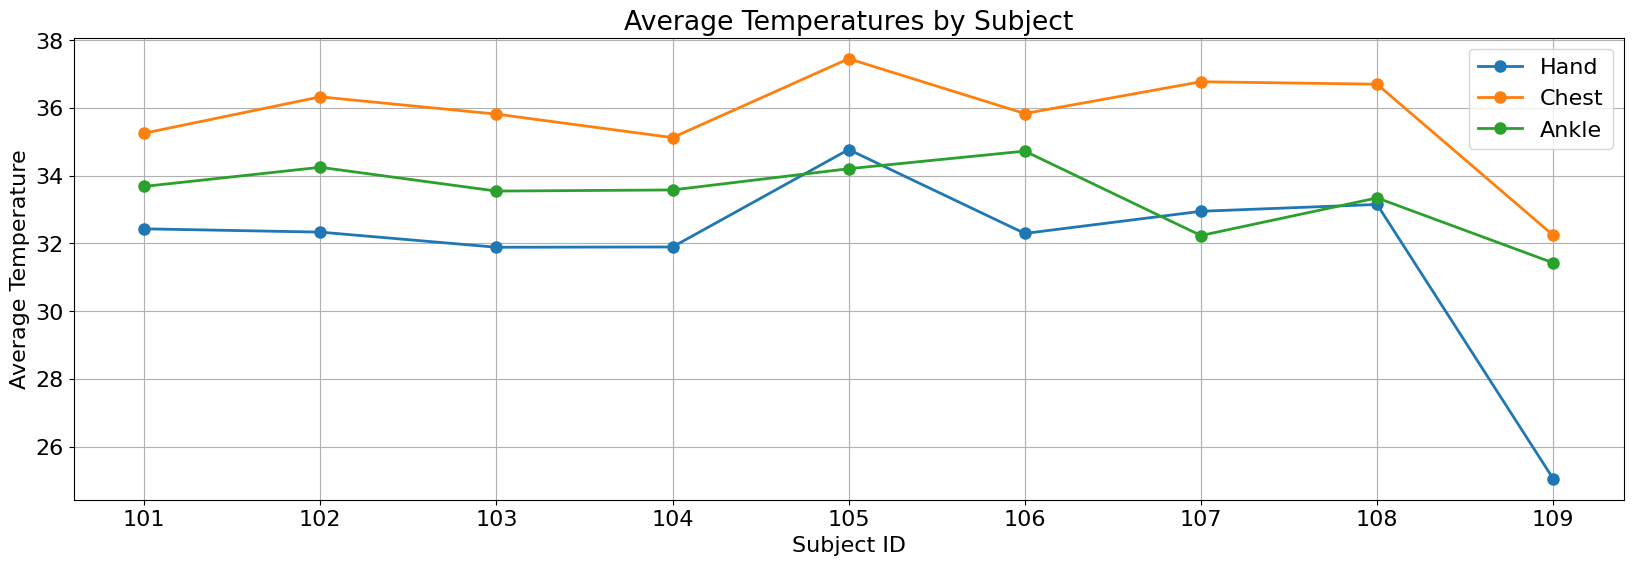

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
# Convert temperature columns to numeric
data['hand_temperature'] = pd.to_numeric(data['hand_temperature'], errors='coerce')
data['chest_temperature'] = pd.to_numeric(data['chest_temperature'], errors='coerce')
data['ankle_temperature'] = pd.to_numeric(data['ankle_temperature'], errors='coerce')

# Group by 'id' and calculate the average temperatures for each subject
average_hand_temperature = data.groupby('id')['hand_temperature'].mean()
average_chest_temperature = data.groupby('id')['chest_temperature'].mean()
average_ankle_temperature = data.groupby('id')['ankle_temperature'].mean()

# Create a DataFrame with temperature data
averages_temperature = pd.DataFrame()
averages_temperature['Hand'] = average_hand_temperature
averages_temperature['Chest'] = average_chest_temperature
averages_temperature['Ankle'] = average_ankle_temperature

# Plot the line graph with grids
plt.figure(figsize=(10, 6))
averages_temperature.plot(kind='line',figsize=(20, 6), marker='o', linewidth=2, markersize=8)
plt.title('Average Temperatures by Subject')
plt.xlabel('Subject ID')
plt.ylabel('Average Temperature')
plt.grid(True)  # Add grid lines
plt.show()


#Sensor Analysis

<Figure size 1000x600 with 0 Axes>

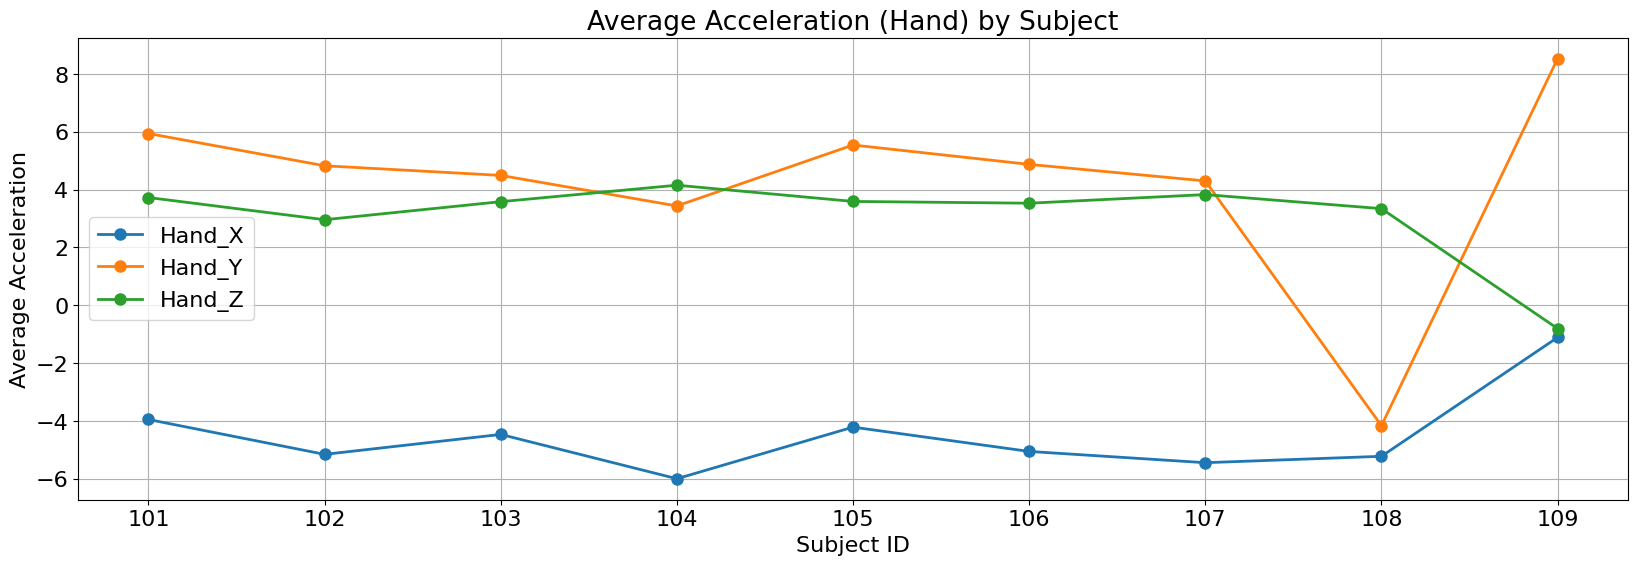

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
# Convert acceleration columns to numeric
data['hand_3D_acceleration_16_x'] = pd.to_numeric(data['hand_3D_acceleration_16_x'], errors='coerce')
data['hand_3D_acceleration_16_y'] = pd.to_numeric(data['hand_3D_acceleration_16_y'], errors='coerce')
data['hand_3D_acceleration_16_z'] = pd.to_numeric(data['hand_3D_acceleration_16_z'], errors='coerce')

# Group by 'id' and calculate the average accelerations for each subject
average_hand_x = data.groupby('id')['hand_3D_acceleration_16_x'].mean()
average_hand_y = data.groupby('id')['hand_3D_acceleration_16_y'].mean()
average_hand_z = data.groupby('id')['hand_3D_acceleration_16_z'].mean()

# Create a DataFrame with acceleration data
averages_acceleration = pd.DataFrame()
averages_acceleration['Hand_X'] = average_hand_x
averages_acceleration['Hand_Y'] = average_hand_y
averages_acceleration['Hand_Z'] = average_hand_z

# Plot the line graph with grids
plt.figure(figsize=(10, 6))
averages_acceleration.plot(kind='line',figsize=(20, 6), marker='o', linewidth=2, markersize=8)
plt.title('Average Acceleration (Hand) by Subject')
plt.xlabel('Subject ID')
plt.ylabel('Average Acceleration')
plt.grid(True)  # Add grid lines
plt.show()


#Making 3 different dataframes

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split

In [ ]:
train_df = data.sample(frac=0.8, random_state=1)
test_df = data.drop(train_df.index)
train_df

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
446209,703.56,3,88.000000,34.1250,-8.83292,4.41122,0.393238,-8.711150,4.49021,0.717680,...,0.023645,0.024118,-19.63100,-16.72450,35.82540,0.124005,-0.698721,0.243934,-0.660991,102
2192250,504.16,2,75.553704,31.8750,-2.05683,6.57929,6.914820,-1.706560,6.63550,7.153840,...,-0.009329,-0.024130,-4.94290,-7.34023,11.61130,0.161762,-0.746433,0.334580,-0.552022,107
1184855,1091.76,16,102.000000,33.6250,-6.61015,7.27180,3.996210,-6.532140,7.27183,4.378840,...,0.092605,-0.056073,-39.15070,13.53510,50.47060,0.106105,0.790671,0.108779,0.593084,104
64136,649.74,3,104.918254,32.9375,-8.43003,3.33582,3.520380,-8.363600,3.38807,3.754990,...,-0.006850,0.027077,-97.92290,-30.01680,31.74410,1.000000,0.000000,0.000000,0.000000,101
938252,1153.99,16,88.000000,32.8750,-1.42405,10.09280,1.562700,-1.359880,10.29770,1.633680,...,0.043931,-0.016507,-36.40120,21.24300,37.72910,0.193861,0.740144,0.032264,0.643089,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2366988,2251.54,4,100.000000,32.9375,-8.49625,2.02178,0.791216,-8.386390,1.72431,0.889516,...,0.881161,-2.399710,-40.47740,1.32190,34.02760,0.087462,0.704509,0.414271,0.569559,107
2803156,3477.20,5,118.992901,30.9375,-5.17240,-49.51550,-6.028320,-0.671078,-46.93720,-6.124230,...,0.258554,5.093250,-45.30760,20.26690,2.64371,0.518941,0.320010,0.780212,0.139872,108
681767,3059.14,4,124.982516,31.0625,-9.12849,1.38546,1.207250,-9.407440,1.46051,1.615980,...,0.466812,-1.636870,-37.78210,-12.54140,1.23662,0.498930,-0.454571,0.589013,-0.444407,102
1890336,1103.16,16,82.000000,34.0000,-5.39264,5.83516,5.635760,-5.113470,6.00951,5.890230,...,-0.111545,-0.046389,-24.17850,4.28457,48.26470,0.052423,0.798427,-0.076435,0.594915,106


In [ ]:
print(data.columns)

Index(['time_stamp', 'activity_id', 'heart_rate', 'hand_temperature',
       'hand_3D_acceleration_16_x', 'hand_3D_acceleration_16_y',
       'hand_3D_acceleration_16_z', 'hand_3D_acceleration_6_x',
       'hand_3D_acceleration_6_y', 'hand_3D_acceleration_6_z',
       'hand_3D_gyroscope_x', 'hand_3D_gyroscope_y', 'hand_3D_gyroscope_z',
       'hand_3D_magnetometer_x', 'hand_3D_magnetometer_y',
       'hand_3D_magnetometer_z', 'hand_4D_orientation_x',
       'hand_4D_orientation_y', 'hand_4D_orientation_z',
       'hand_4D_orientation_w', 'chest_temperature',
       'chest_3D_acceleration_16_x', 'chest_3D_acceleration_16_y',
       'chest_3D_acceleration_16_z', 'chest_3D_acceleration_6_x',
       'chest_3D_acceleration_6_y', 'chest_3D_acceleration_6_z',
       'chest_3D_gyroscope_x', 'chest_3D_gyroscope_y', 'chest_3D_gyroscope_z',
       'chest_3D_magnetometer_x', 'chest_3D_magnetometer_y',
       'chest_3D_magnetometer_z', 'chest_4D_orientation_x',
       'chest_4D_orientation_y', 'che

In [ ]:
# hand  ---> 'hand_temperature',
#        'hand_3D_acceleration_16_x', 'hand_3D_acceleration_16_y',
#        'hand_3D_acceleration_16_z', 'hand_3D_acceleration_6_x',
#        'hand_3D_acceleration_6_y', 'hand_3D_acceleration_6_z',
#        'hand_3D_gyroscope_x', 'hand_3D_gyroscope_y', 'hand_3D_gyroscope_z',
#        'hand_3D_magnetometer_x', 'hand_3D_magnetometer_y',
#        'hand_3D_magnetometer_z', 'hand_4D_orientation_x',
#        'hand_4D_orientation_y', 'hand_4D_orientation_z',
#        'hand_4D_orientation_w',


# chest ---->'chest_temperature',
#        'chest_3D_acceleration_16_x', 'chest_3D_acceleration_16_y',
#        'chest_3D_acceleration_16_z', 'chest_3D_acceleration_6_x',
#        'chest_3D_acceleration_6_y', 'chest_3D_acceleration_6_z',
#        'chest_3D_gyroscope_x', 'chest_3D_gyroscope_y', 'chest_3D_gyroscope_z',
#        'chest_3D_magnetometer_x', 'chest_3D_magnetometer_y',
#        'chest_3D_magnetometer_z', 'chest_4D_orientation_x',
#        'chest_4D_orientation_y', 'chest_4D_orientation_z',
#        'chest_4D_orientation_w',


# ankle---->  'ankle_temperature',
#        'ankle_3D_acceleration_16_x', 'ankle_3D_acceleration_16_y',
#        'ankle_3D_acceleration_16_z', 'ankle_3D_acceleration_6_x',
#        'ankle_3D_acceleration_6_y', 'ankle_3D_acceleration_6_z',
#        'ankle_3D_gyroscope_x', 'ankle_3D_gyroscope_y', 'ankle_3D_gyroscope_z',
#        'ankle_3D_magnetometer_x', 'ankle_3D_magnetometer_y',
#        'ankle_3D_magnetometer_z', 'ankle_4D_orientation_x',
#        'ankle_4D_orientation_y', 'ankle_4D_orientation_z',
#        'ankle_4D_orientation_w',


In [ ]:
import pandas as pd

# Assuming 'data' is your original DataFrame

# Hand DataFrame
hand_columns = [
    'hand_temperature',
    'hand_3D_acceleration_16_x', 'hand_3D_acceleration_16_y',
    'hand_3D_acceleration_16_z', 'hand_3D_acceleration_6_x',
    'hand_3D_acceleration_6_y', 'hand_3D_acceleration_6_z',
    'hand_3D_gyroscope_x', 'hand_3D_gyroscope_y',
    'hand_3D_gyroscope_z', 'hand_3D_magnetometer_x',
    'hand_3D_magnetometer_y', 'hand_3D_magnetometer_z',
    'hand_4D_orientation_x', 'hand_4D_orientation_y',
    'hand_4D_orientation_z', 'hand_4D_orientation_w'
]
hand_df = pd.DataFrame(train_df[hand_columns])

# Chest DataFrame
chest_columns = [
    'chest_temperature',
    'chest_3D_acceleration_16_x', 'chest_3D_acceleration_16_y', 'chest_3D_acceleration_16_z',
    'chest_3D_acceleration_6_x', 'chest_3D_acceleration_6_y', 'chest_3D_acceleration_6_z',
    'chest_3D_gyroscope_x', 'chest_3D_gyroscope_y', 'chest_3D_gyroscope_z',
    'chest_3D_magnetometer_x', 'chest_3D_magnetometer_y', 'chest_3D_magnetometer_z',
    'chest_4D_orientation_x', 'chest_4D_orientation_y', 'chest_4D_orientation_z', 'chest_4D_orientation_w'
]
chest_df = pd.DataFrame(train_df[chest_columns])

# Ankle DataFrame
ankle_columns = [
    'ankle_temperature',
    'ankle_3D_acceleration_16_x', 'ankle_3D_acceleration_16_y', 'ankle_3D_acceleration_16_z',
    'ankle_3D_acceleration_6_x', 'ankle_3D_acceleration_6_y', 'ankle_3D_acceleration_6_z',
    'ankle_3D_gyroscope_x', 'ankle_3D_gyroscope_y', 'ankle_3D_gyroscope_z',
    'ankle_3D_magnetometer_x', 'ankle_3D_magnetometer_y', 'ankle_3D_magnetometer_z',
    'ankle_4D_orientation_x', 'ankle_4D_orientation_y', 'ankle_4D_orientation_z', 'ankle_4D_orientation_w'
]
ankle_df = pd.DataFrame(train_df[ankle_columns])


In [ ]:
len(train_df)

1608574

In [ ]:
train_df = train_df.drop(["time_stamp", "id"],axis=1)
train_df

,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,hand_3D_gyroscope_x,...,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w
446209,3,88.000000,34.1250,-8.83292,4.41122,0.393238,-8.711150,4.49021,0.717680,0.028474,...,-0.062677,0.023645,0.024118,-19.63100,-16.72450,35.82540,0.124005,-0.698721,0.243934,-0.660991
2192250,2,75.553704,31.8750,-2.05683,6.57929,6.914820,-1.706560,6.63550,7.153840,0.026814,...,-0.019579,-0.009329,-0.024130,-4.94290,-7.34023,11.61130,0.161762,-0.746433,0.334580,-0.552022
1184855,16,102.000000,33.6250,-6.61015,7.27180,3.996210,-6.532140,7.27183,4.378840,-0.000288,...,0.050910,0.092605,-0.056073,-39.15070,13.53510,50.47060,0.106105,0.790671,0.108779,0.593084
64136,3,104.918254,32.9375,-8.43003,3.33582,3.520380,-8.363600,3.38807,3.754990,-0.001992,...,-0.027016,-0.006850,0.027077,-97.92290,-30.01680,31.74410,1.000000,0.000000,0.000000,0.000000
938252,16,88.000000,32.8750,-1.42405,10.09280,1.562700,-1.359880,10.29770,1.633680,-1.973780,...,-0.006768,0.043931,-0.016507,-36.40120,21.24300,37.72910,0.193861,0.740144,0.032264,0.643089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2366988,4,100.000000,32.9375,-8.49625,2.02178,0.791216,-8.386390,1.72431,0.889516,0.253304,...,-1.004960,0.881161,-2.399710,-40.47740,1.32190,34.02760,0.087462,0.704509,0.414271,0.569559
2803156,5,118.992901,30.9375,-5.17240,-49.51550,-6.028320,-0.671078,-46.93720,-6.124230,0.614104,...,1.809460,0.258554,5.093250,-45.30760,20.26690,2.64371,0.518941,0.320010,0.780212,0.139872
681767,4,124.982516,31.0625,-9.12849,1.38546,1.207250,-9.407440,1.46051,1.615980,-0.791990,...,-0.013290,0.466812,-1.636870,-37.78210,-12.54140,1.23662,0.498930,-0.454571,0.589013,-0.444407
1890336,16,82.000000,34.0000,-5.39264,5.83516,5.635760,-5.113470,6.00951,5.890230,-0.082827,...,-0.031454,-0.111545,-0.046389,-24.17850,4.28457,48.26470,0.052423,0.798427,-0.076435,0.594915


#Modelling
Some variables have to be dropped which would impact our modelling precision. The variables to be dropped are timestamp and subject_id as they are numeric numbers which would our modelling method would use in its calculations but since their values don't have any meaning, the modelling method used would have noise and predictions of accuracy would be innacurate.

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedShuffleSplit
from sklearn.metrics import precision_score,recall_score, f1_score, confusion_matrix,roc_auc_score,roc_curve, accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#apply scaling to all columns except subject and activity
scaler = RobustScaler()
df_scaled = train_df.copy()
df_scaled_test = test_df.copy()

df_scaled.iloc[:,1:41] = scaler.fit_transform(df_scaled.iloc[:,1:41])
df_scaled_test.iloc[:,1:41] = scaler.fit_transform(df_scaled_test.iloc[:,1:41])

df_scaled.head()

In [ ]:
X_train = df_scaled.drop('activity_id', axis=1).values
y_train = df_scaled['activity_id'].values

# Test Dataset
X_test = df_scaled.drop('activity_id', axis=1).values
y_test = df_scaled['activity_id'].values

#Dimensionality reduction using Principal Component Analysis(PCA)
Usually 90-98% of the variance will explain our data really well. So by plotting the variance ratio aginst the number of componments we could see how many of those we could use. As we see from the graph below 15 componments fall around to 94% of the variance.

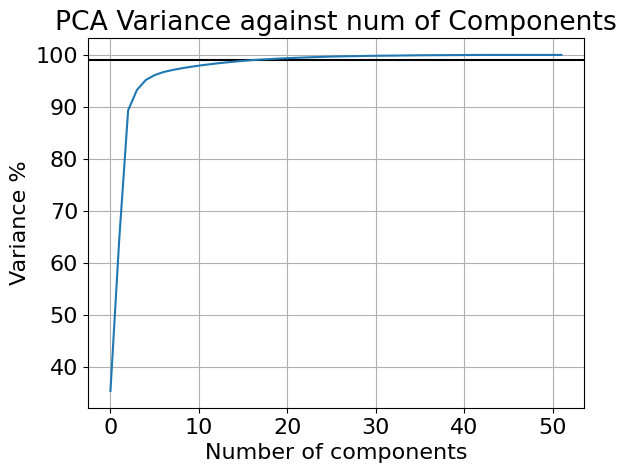

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
var= pca.explained_variance_ratio_
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

plt.title("PCA Variance against num of Components")
plt.ylabel("Variance %")
plt.xlabel("Number of components")
l = plt.axhline(99, color="black")

plt.plot(var1)
plt.grid()

In [ ]:
pca = PCA(n_components=17)
X_train=pca.fit_transform(X_train)
X_test=pca.fit_transform(X_test)

In [ ]:
#creating smaller train and test samples
len(X_train)

1608574

In [ ]:
import random
listofindices=[]
while len(listofindices)==230:
    l.append(random.randint(0,2298026))

**Random Forest algorithm** can be used for both classification and regression which makes it a very versatile modelling algorithm. As the name implies, Random Forest is a forest of trees, decision trees which are randomly populating the forest. The algorithms creates and combines decision trees together, the more trees in the forest, the better the accuracy of its predictions will be.

Random Forest algorithms are good because of the high accuracy they provide as well as that they are flexible i.e. can work for both classification and regression modelling. In addition, Random Forest facilitates for good performance of high dimensionality datasets which our dataset has.

In [ ]:
def get_metrics (y_true,y_pred):
    acc = accuracy_score(y_true, y_pred)
    err = 1-acc
    p = precision_score(y_true, y_pred,average=None).mean()
    r = recall_score(y_true, y_pred, average=None).mean()
    f1 = f1_score(y_true, y_pred, average=None).mean()

    print("Accuracy: ",acc)
    print("Error: ",acc)
    print("Precision", p)
    print("Recall", r)
    print("F1", f1)
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs =4)
y_train=np.rint(y_train).astype(int)
print(y_train)
rfc.fit(X_train,y_train)
y_pred_rf = rfc.predict(X_test)
get_metrics(y_test,y_pred_rf)

[ 3  2 17 ...  4 17  3]


KeyboardInterrupt: ignored

# Cross validation
Even though the above models seem to perform really good, the metrics used for that do not represent the real score since the models were train on a specific part of the dataset. By using cross validation, we could k=10 number of folds, which in few words, will generate 10 different samples. By doing that we will get 10 different metrics values. The mean value of these metrics will show a better representation of our model's performance

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

classifiers = [RandomForestClassifier(n_jobs =4)]

score_lst = []
for cls in classifiers:
    accs  = accuracy_score(y_train, cross_val_predict(cls,X_train,y_train,cv = 10))  #cross validate the accurancy
    scores = cross_val_score(cls,X_train,y_train,scoring = "neg_mean_squared_error",cv= 10)#calcuate the error
    score = np.sqrt(-scores)
    f1 = cross_val_score(cls,X_test, y_test,scoring = "f1_macro", cv =10)


    #p = cross_val_score(cls,X_test, y_test,scoring = "average_precision", cv =10)
#     r = recall_score(y_true, y_pred, average=None).mean()
#     f1 = f1_score(y_true, y_pred, average=None).mean()
    score_lst.append([cls.__class__.__name__,accs,score.mean(), f1.mean()])

df_scores=pd.DataFrame(columns = ["Claasifier","Accurancy","MSE","F1"],data =  score_lst)
display(df_scores)

new repo from below https://www.kaggle.com/code/lejitran/wrap-up

In [ ]:
IMU_columns = ['temp', 'acc_x_sc16', 'acc_y_sc16', 'acc_z_sc16',
                'acc_x_sc6', 'acc_y_sc6', 'acc_z_sc6',
                'gyro_x', 'gyro_y', 'gyro_z',
                'mag_x', 'mag_y', 'mag_z',
                'orient_x', 'orient_y', 'orient_z', 'orient_w']

cols = ['timestamp', 'activity_id', 'heart-rate'] + [f'IMU_{x}_{i}' for x in ['hand', 'chest', 'ankle']  for i in IMU_columns]
def load_subjects(root='/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject'):
    subjects = []

    for i in range(101,110):
        path = root + str(i) +'.dat'
        subject = pd.read_table(path, header=None, sep='\s+')
        subject.columns = cols
        subject['id'] = i
        subjects.append(subject)

    return subjects

data = load_subjects()

In [ ]:
def fix_data(data):
    output = []
    for subject in data:
        subject = subject.drop(subject[subject['activity_id']==0].index)
        subject = subject.interpolate()
        output.append(subject)
    return output

fixed_data = fix_data(data)

In [ ]:
def check_null(data):
    for idx, subject in enumerate(data):
        no_null_values = subject.isnull().sum().sum()
        print(f'Subject 10{idx + 1}: {no_null_values} null value')

check_null(fixed_data)

Subject 101: 4 null value
Subject 102: 5 null value
Subject 103: 6 null value
Subject 104: 9 null value
Subject 105: 5 null value
Subject 106: 6 null value
Subject 107: 5 null value
Subject 108: 0 null value
Subject 109: 2 null value


In [ ]:
for idx, subject in enumerate(fixed_data):
    no_null_values = subject.isnull().sum().sum()
    subject['heart-rate'][:no_null_values] = subject['heart-rate'].iloc[no_null_values+1]

check_null(fixed_data)

<ipython-input-16-b85961a19717>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject['heart-rate'][:no_null_values] = subject['heart-rate'].iloc[no_null_values+1]
<ipython-input-16-b85961a19717>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject['heart-rate'][:no_null_values] = subject['heart-rate'].iloc[no_null_values+1]
<ipython-input-16-b85961a19717>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject['heart-rate'][:n

Subject 101: 0 null value
Subject 102: 0 null value
Subject 103: 0 null value
Subject 104: 0 null value
Subject 105: 0 null value
Subject 106: 0 null value
Subject 107: 0 null value
Subject 108: 0 null value
Subject 109: 0 null value


In [ ]:
all_data = pd.concat(fixed_data)

[Text(0, 0, '109'),
 Text(1, 0, '103'),
 Text(2, 0, '104'),
 Text(3, 0, '107'),
 Text(4, 0, '101'),
 Text(5, 0, '106'),
 Text(6, 0, '108'),
 Text(7, 0, '102'),
 Text(8, 0, '105')]

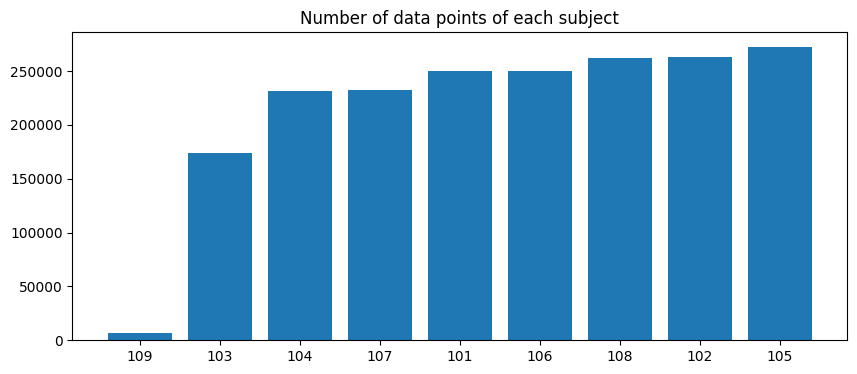

In [ ]:
samples = all_data.groupby(['id']).count().reset_index()
samples_to_subject = pd.DataFrame()
samples_to_subject['id'] = samples['id']
samples_to_subject['samples'] = samples['timestamp']
samples_to_subject = samples_to_subject.sort_values(by=['samples'])

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(range(len(samples_to_subject)), samples_to_subject['samples'])
ax.set_xticks(np.arange(len(samples_to_subject)))
ax.set_title("Number of data points of each subject")
ax.set_xticklabels(samples_to_subject['id'])

In [ ]:
samples = all_data.groupby(['activity_id']).count().reset_index()
samples_to_subject = pd.DataFrame()
samples_to_subject['activity_id'] = samples['activity_id']
samples_to_subject['samples'] = samples['timestamp']
samples_to_subject = samples_to_subject.sort_values(by=['samples'])
def to_continuous_arrs(arr: list):
    if not len(arr):
        return

    res = []
    subarr = [arr[0]]
    for i in range(len(arr)-1):
        if (arr[i+1] - arr[i] == 1):
            subarr.append(arr[i+1])
        else:
            res.append(subarr)
            subarr = [arr[i+1]]
    res.append(subarr)

    return res
def delete_begin_end_secs(activity_idxs: list, sec=10):
    res = []
    samples = int(sec * 100)
    for idx_list in activity_idxs:
        res += idx_list[samples:-samples]
    return res

# 4.1. Trim down sensor data
To avoid dealing with eventual transient activities, 10 seconds from the beginning and the end of each labeled activity is deleted, respectively.

In [ ]:
trimmed_data = []
for subject in fixed_data:
    activity_ids = subject['activity_id'].unique()
    indices = []
    for activity_id in activity_ids:
        idx_list = to_continuous_arrs(subject[subject['activity_id']==activity_id].index)
        indices += delete_begin_end_secs(idx_list)
    trimmed_data.append(subject.loc[indices])

In [ ]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from itertools import product

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix, classification_report, precision_score, recall_score

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# 4.2. Segmentation
Previous work shows that for segmentation there is no single best window length for all activities. To obtain at least 2 or 3 periods of all different periodic movements, a window length of about 3-5 seconds is reasonable. Therefore, and to assure effective FFT-calculation, a window size of 512 samples was selected. The preprocessed data is segmented using a sliding window with the defined 5.12 seconds of window size, shifted by 1 second between consecutive windows.

In [ ]:
def moving_window(df, length=512, shift=100):
    size = df.shape[0]
    prev = 0
    for start in range(0, size, length-shift):
        yield df[start:start + length] if start + length < size else df[start:size]

In [ ]:
def get_peaks_DFT(t, f, top=5, dt=0.01):
    n = len(t)
    fhat = np.fft.fft(f, n)
    PSD = fhat * np.conj(fhat) / n
    freq = (1/(dt*n)) * np.arange(n)
    L = np.arange(1, np.floor(n/2), dtype='int')

    top_index = np.argsort(PSD, )[::-1][:top]
    return list(PSD[top_index].astype(np.float64)), list(top_index)

In [ ]:
N_FFT_PEAKS = 5

subject = trimmed_data[0]
columns=['activity_id']
new_feats = ['max', 'min', 'mean', 'var', 'skew', 'kurtosis']
fft_feats = [f'top{i}_{k}' for k in ['PSD', 'freq'] for i in range(1, N_FFT_PEAKS+1)]
new_feats += fft_feats
new_cols = [f'{feat}_{col}' for col in subject.columns[4:-1] for feat in new_feats]
columns += new_cols + ['id']

In [ ]:
rows = []
for subject in trimmed_data:
    for segment in moving_window(subject):
        row = []
        row.append(segment['activity_id'].mode()[0])
        t = segment['timestamp']
        for i in range(4, len(segment.columns)-1):
            series = segment.iloc[:, i]
            row.append(series.max())
            row.append(series.min())
            row.append(series.mean())
            row.append(series.var())
            row.append(series.skew())
            row.append(series.kurtosis())
            top_PSDs, top_freqs = get_peaks_DFT(t, series, top=N_FFT_PEAKS)
            row += top_PSDs + top_freqs
            row.append(segment['id'].iloc[0])
        rows.append(row)
segmented = pd.DataFrame(rows, columns=columns)
segmented.shape

<ipython-input-25-09d9062d3353>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  return list(PSD[top_index].astype(np.float64)), list(top_index)
<ipython-input-25-09d9062d3353>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  return list(PSD[top_index].astype(np.float64)), list(top_index)
<ipython-input-25-09d9062d3353>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  return list(PSD[top_index].astype(np.float64)), list(top_index)
<ipython-input-25-09d9062d3353>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  return list(PSD[top_index].astype(np.float64)), list(top_index)
<ipython-input-25-09d9062d3353>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  return list(PSD[top_index].astype(np.float64)), list(top_index)
<ipython-input-25-09d9062d3353>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  return l

KeyboardInterrupt: ignored

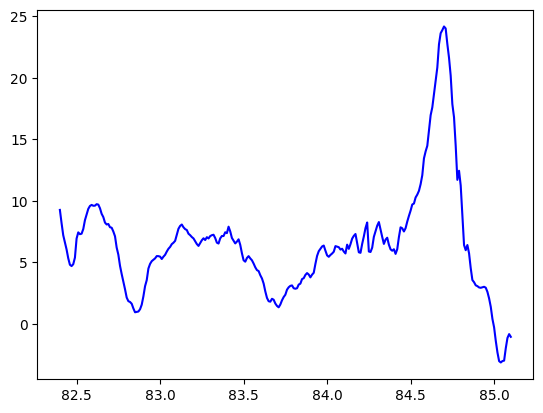

In [ ]:
dt = 0.01
t = segment.iloc[:, 0]
f = segment.iloc[:, 5]
plt.plot(t, f, color='blue')

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


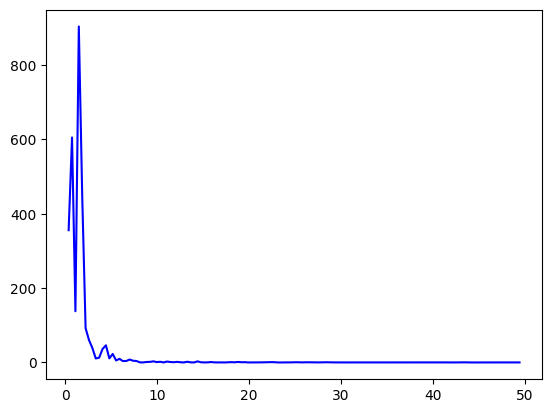

In [ ]:
n = len(t)
fhat = np.fft.fft(f, n)
PSD = fhat * np.conj(fhat) / n
freq = (1/(dt*n)) * np.arange(n)
L = np.arange(1, np.floor(n/2), dtype='int')

plt.plot(freq[L], PSD[L], color='blue')

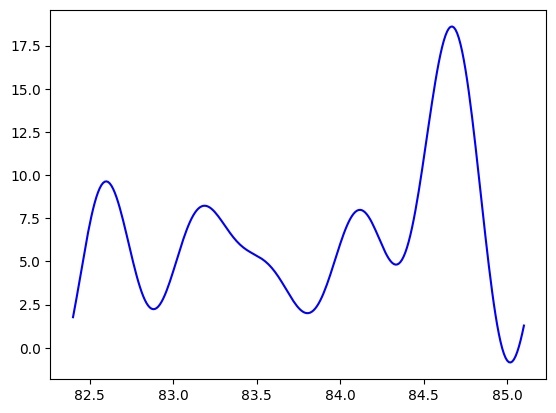

In [ ]:
indices = PSD > 100       # Find all freqs with large power
PSDclean = PSD * indices  # Zero out all others
fhat = indices * fhat     # Zero out small Fourier coeffs. in Y
ffilt = np.fft.ifft(fhat) # Inverse FFT for filtered time signal

plt.plot(t,ffilt,color='blue')

In [ ]:
# utility function
def iter(grid):
    params_lst = []
    grid_wrapper = [grid]
    for p in grid_wrapper:
        # Always sort the keys of a dictionary, for reproducibility
        items = sorted(p.items())
        keys, values = zip(*items)
        for v in product(*values):
            params = dict(zip(keys, v))
            params_lst.append(params)
    return params_lst

In [ ]:
def split_train_test(data, scaler):
    # create the test data
    subject107 = data[data['id'] == 107]
    subject108 = data[data['id'] == 108]
    test = subject107.append(subject108)

    # create the train data
    train = data[data['id'] != 107]
    train = train[train['id'] != 108]
    test = test.drop(["id"], axis=1)
    train = train.drop(["id"], axis=1)

    # split train and test to X and y
    X_train = train.drop(['activity_id'], axis=1).values
    X_test = test.drop(['activity_id'], axis=1).values

    if scaler == 'StandardScaler':
        scaler = StandardScaler()
        scaler.fit(X_train)
        scaler.fit(X_test)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    if scaler == 'MinMaxScaler':
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        scaler.fit(X_test)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    elif scaler == 'PowerTransformer':
        scaler = PowerTransformer()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)

    y_train = train['activity_id'].values
    y_test = test['activity_id'].values
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = split_train_test(segmented, 'StandardScaler')
print('Train shape X :',X_train.shape,' y ', y_train.shape)
print('Test shape X :',X_test.shape,' y ', y_test.shape)

Train shape X : (3134, 800)  y  (3134,)
Test shape X : (1071, 800)  y  (1071,)


In [ ]:
X_train


array([[ 0.13459761,  0.09113772,  0.75170038, ..., -0.40773612,
        -0.51285518, -0.18403835],
       [-0.19843321,  1.22953474,  1.25396164, ..., -0.40773612,
        -0.51285518, -0.18403835],
       [ 0.63362134,  1.23506242,  2.08420384, ..., -0.40773612,
        -0.51285518, -0.18403835],
       ...,
       [ 1.62267268,  0.74653258,  1.47285735, ..., -1.02411041,
         0.82160325, -0.77373796],
       [ 1.61153154, -0.11324781,  1.06836801, ...,  0.97515493,
        -1.15403641,  1.21750797],
       [-0.14686786,  0.26593572, -0.47320152, ...,  0.01898455,
        -0.08005785, -0.83836257]])



In [ ]:
CV_TYPES = ['Stratified Random Sampling', 'Leave-one-out', 'K-Fold']
result_info = {'Model': [],
               'Validation-Accuracy': [],
               'Accuracy': [],
               'Precision': [],
               'Recall': [],
               'F1-score': [],
               'Best Hyper-paramerters': [],
               'Training Time': [],
               'Cross-validation': []}

In [ ]:
def get_dict_score(model, grid, cv_type, scaler):
    score_array = []
    best_score = [0,0]
    start_time = time.time()
    if cv_type == 'Stratified Random Sampling':
        for params in iter(grid):
            print("Stratified Random Sampling - Running on params: ", params)
            sss = StratifiedShuffleSplit(n_splits = 10, test_size = 1/3, random_state = 42)
            accuracy_sss = []
            for train_index, test_index in sss.split(X_train, y_train):
                X_train_sss, X_test_sss = X_train[train_index], X_train[test_index]
                y_train_sss, y_valid_sss = y_train[train_index], y_train[test_index]
                sss_model = model.set_params(**params)
                sss_model.fit(X_train_sss, y_train_sss)
                # evaluate model
                preds_sss = sss_model.predict(X_test_sss)
                # store accuracy
                accuracy_sss.append(accuracy_score(preds_sss, y_valid_sss))
            score_dict = {}
            score_dict['params'] = params
            score_dict['mean'] = np.mean(accuracy_sss)
            score_dict['std'] = np.std(accuracy_sss)
            score_array.append(score_dict)
            if score_dict['mean'] >= best_score[0]:
                best_score[0] = score_dict['mean']
                best_score[1] = score_dict['std']

    elif cv_type == 'Leave-one-out':
        for params in iter(grid):
            print("L1O - Running on params: ", params)
            accuracy = []

            X_train_re = segmented[segmented['id'] != 107]
            X_train_re = X_train_re[X_train_re['id'] != 108]

            y_train_re = X_train_re['activity_id']
            X_train_re = X_train_re.drop(['activity_id'], axis=1)

            for subject in [101,102,103,104,105,106,109]:
                train_index = X_train_re[X_train_re['id'] != subject].index
                valid_index = X_train_re[X_train_re['id'] == subject].index

                X_train_l1o, y_train_l1o = X_train_re.loc[train_index], y_train_re.loc[train_index]
                X_valid_l1o, y_valid_l1o = X_train_re.loc[valid_index], y_train_re.loc[valid_index]

                X_train_l1o = X_train_l1o.drop(['id'], axis=1)
                X_valid_l1o = X_valid_l1o.drop(['id'], axis=1)

                if scaler == 'StandardScaler':
                    scaler = StandardScaler()
                    scaler.fit(X_train_l1o)
                    scaler.fit(X_valid_l1o)
                    X_train_l1o = scaler.transform(X_train_l1o)
                    X_valid_l1o = scaler.transform(X_valid_l1o)
                if scaler == 'MinMaxScaler':
                    scaler = MinMaxScaler()
                    scaler.fit(X_train_l1o)
                    scaler.fit(X_test)
                    X_train_l1o = scaler.transform(X_train_l1o)
                    X_valid_l1o = scaler.transform(X_valid_l1o)
                elif scaler == 'PowerTransformer':
                    scaler = PowerTransformer()
                    X_train_l1o = scaler.fit_transform(X_train_l1o)
                    X_valid_l1o = scaler.fit_transform(X_valid_l1o)

                #train the model
                l1o_model = model.set_params(**params)
                l1o_model.fit(X_train_l1o, y_train_l1o)
                # evaluate model
                preds = l1o_model.predict(X_valid_l1o)
                # store
                accuracy.append(accuracy_score(preds, y_valid_l1o))

                score_dict = {}
                score_dict['params'] = params
                score_dict['mean'] = np.mean(accuracy)
                score_dict['std'] = np.std(accuracy)
                score_array.append(score_dict)
                if score_dict['mean'] >= best_score[0]:
                    best_score[0] = score_dict['mean']
                    best_score[1] = score_dict['std']


    elif cv_type == 'K-Fold':
        p_fold_cv = KFold(n_splits=10, shuffle=True, random_state=42)
        for params in iter(grid):
            print("KFold - Running on params: ", params)
            p_fold_model = model.set_params(**params)
            scores = cross_val_score(p_fold_model, X_test, y_test, scoring='accuracy', cv=p_fold_cv, n_jobs=-1)
            score_dict = {}
            score_dict['params'] = params
            score_dict['mean'] = scores.mean()
            score_dict['std'] = scores.std()
            score_array.append(score_dict)
            if score_dict['mean'] >= best_score[0]:
                best_score[0] = score_dict['mean']
                best_score[1] = score_dict['std']

    executed_time = time.time() - start_time
    return score_array, executed_time, best_score

In [ ]:
def get_best_param(cv_score):
    best_score = 0
    best_param = {}
    for params in cv_score:
        if params['mean'] > best_score:
            best_score = params['mean']
            best_param = params
    return best_param['params']
def performance_info(model, best_params):
    opt_model = model.set_params(**best_params)
    opt_model.fit(X_train, y_train)
    pred_test = opt_model.predict(X_test)
    result_info['Model'].append(type(model).__name__)
    result_info['Validation-Accuracy'].append(str(best_score[0].round(6)*100) + '+-' + str(best_score[1].round(6)*100))
    result_info['Accuracy'].append(accuracy_score(y_test, pred_test).round(6)*100)
    result_info['Precision'].append(precision_score(y_test, pred_test, average = 'macro').round(6)*100)
    result_info['Recall'].append(recall_score(y_test, pred_test, average = 'macro').round(6)*100)
    result_info['F1-score'].append(f1_score(y_test, pred_test, average = 'macro').round(6)*100)
    result_info['Best Hyper-paramerters'].append(get_best_param(score))
    result_info['Training Time'].append(str(training_time) + 's')
    result_info['Cross-validation'].append(cv_type)

In [ ]:
lr_grid = {'C': [0.001,0.01,0.1,1,10,100,1000]}
X_train, X_test, y_train, y_test = split_train_test(segmented, scaler='StandardScaler')
for cv_type in CV_TYPES:
    lr = LogisticRegression(max_iter=250)
    score, training_time, best_score = get_dict_score(lr, lr_grid, cv_type, scaler='StandardScaler')
    best_params = get_best_param(score)
    performance_info(lr, best_params)


Stratified Random Sampling - Running on params:  {'C': 0.001}
Stratified Random Sampling - Running on params:  {'C': 0.01}
Stratified Random Sampling - Running on params:  {'C': 0.1}
Stratified Random Sampling - Running on params:  {'C': 1}
Stratified Random Sampling - Running on params:  {'C': 10}
Stratified Random Sampling - Running on params:  {'C': 100}
Stratified Random Sampling - Running on params:  {'C': 1000}
L1O - Running on params:  {'C': 0.001}
L1O - Running on params:  {'C': 0.01}
L1O - Running on params:  {'C': 0.1}
L1O - Running on params:  {'C': 1}
L1O - Running on params:  {'C': 10}
L1O - Running on params:  {'C': 100}
L1O - Running on params:  {'C': 1000}
KFold - Running on params:  {'C': 0.001}
KFold - Running on params:  {'C': 0.01}
KFold - Running on params:  {'C': 0.1}
KFold - Running on params:  {'C': 1}
KFold - Running on params:  {'C': 10}
KFold - Running on params:  {'C': 100}
KFold - Running on params:  {'C': 1000}



In [ ]:
knn_grid = { 'n_neighbors' : [i for i in range(2,20)],'metric' : ['euclidean','manhattan']}
X_train, X_test, y_train, y_test = split_train_test(segmented, scaler='StandardScaler')
for cv_type in CV_TYPES:
    knn = KNeighborsClassifier(weights='distance')
    score, training_time, best_score = get_dict_score(knn, knn_grid, cv_type, scaler='StandardScaler')
    knn_best_params = get_best_param(score)
    performance_info(knn, knn_best_params)


Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors': 2}
Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors': 3}
Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors': 4}
Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors': 5}
Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors': 6}
Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors': 7}
Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors': 8}
Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors': 9}
Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors': 10}
Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors': 11}
Stratified Random Sampling - Running on params:  {'metric': 'euclidean', 'n_neighbors':

In [ ]:
gnb_grid = {'var_smoothing': np.logspace(0,-9, num=100)}
X_train, X_test, y_train, y_test = split_train_test(segmented, scaler='PowerTranformer')
for cv_type in CV_TYPES:
    gnb = GaussianNB()
    score, training_time, best_score = get_dict_score(gnb, gnb_grid, cv_type, scaler='PowerTranformer')
    best_params = get_best_param(score)
    performance_info(gnb, best_params)

Stratified Random Sampling - Running on params:  {'var_smoothing': 1.0}
Stratified Random Sampling - Running on params:  {'var_smoothing': 0.8111308307896871}
Stratified Random Sampling - Running on params:  {'var_smoothing': 0.657933224657568}
Stratified Random Sampling - Running on params:  {'var_smoothing': 0.533669923120631}
Stratified Random Sampling - Running on params:  {'var_smoothing': 0.43287612810830584}
Stratified Random Sampling - Running on params:  {'var_smoothing': 0.3511191734215131}
Stratified Random Sampling - Running on params:  {'var_smoothing': 0.2848035868435802}
Stratified Random Sampling - Running on params:  {'var_smoothing': 0.23101297000831597}
Stratified Random Sampling - Running on params:  {'var_smoothing': 0.1873817422860384}
Stratified Random Sampling - Running on params:  {'var_smoothing': 0.15199110829529336}
Stratified Random Sampling - Running on params:  {'var_smoothing': 0.12328467394420659}
Stratified Random Sampling - Running on params:  {'var_s

In [ ]:
rf_grid = {'max_depth': [10, 20, 30],'n_estimators': [50, 120, 200]}
X_train, X_test, y_train, y_test = split_train_test(segmented, scaler='StandardScaler')
for cv_type in CV_TYPES:
    rf = RandomForestClassifier(random_state = 42)
    rf_score, training_time, best_score = get_dict_score(rf, rf_grid, cv_type, scaler='StandardScaler')
    best_params = get_best_param(rf_score)
    performance_info(rf, best_params)

Stratified Random Sampling - Running on params:  {'max_depth': 10, 'n_estimators': 50}
Stratified Random Sampling - Running on params:  {'max_depth': 10, 'n_estimators': 120}
Stratified Random Sampling - Running on params:  {'max_depth': 10, 'n_estimators': 200}
Stratified Random Sampling - Running on params:  {'max_depth': 20, 'n_estimators': 50}
Stratified Random Sampling - Running on params:  {'max_depth': 20, 'n_estimators': 120}
Stratified Random Sampling - Running on params:  {'max_depth': 20, 'n_estimators': 200}
Stratified Random Sampling - Running on params:  {'max_depth': 30, 'n_estimators': 50}
Stratified Random Sampling - Running on params:  {'max_depth': 30, 'n_estimators': 120}
Stratified Random Sampling - Running on params:  {'max_depth': 30, 'n_estimators': 200}
L1O - Running on params:  {'max_depth': 10, 'n_estimators': 50}
L1O - Running on params:  {'max_depth': 10, 'n_estimators': 120}
L1O - Running on params:  {'max_depth': 10, 'n_estimators': 200}
L1O - Running on 

In [ ]:
ada_grid = {"base_estimator__criterion" : ["gini", "entropy"],"n_estimators": [5, 10, 25, 50, 75]}
for cv_type in CV_TYPES:
    dtc = DecisionTreeClassifier(random_state = 42)
    ada = AdaBoostClassifier(base_estimator = dtc)
    score, training_time, best_score = get_dict_score(ada, ada_grid, cv_type, scaler='StandardScaler')
    best_params = get_best_param(score)
    performance_info(ada, best_params)

Stratified Random Sampling - Running on params:  {'base_estimator__criterion': 'gini', 'n_estimators': 5}
Stratified Random Sampling - Running on params:  {'base_estimator__criterion': 'gini', 'n_estimators': 10}
Stratified Random Sampling - Running on params:  {'base_estimator__criterion': 'gini', 'n_estimators': 25}
Stratified Random Sampling - Running on params:  {'base_estimator__criterion': 'gini', 'n_estimators': 50}
Stratified Random Sampling - Running on params:  {'base_estimator__criterion': 'gini', 'n_estimators': 75}
Stratified Random Sampling - Running on params:  {'base_estimator__criterion': 'entropy', 'n_estimators': 5}
Stratified Random Sampling - Running on params:  {'base_estimator__criterion': 'entropy', 'n_estimators': 10}
Stratified Random Sampling - Running on params:  {'base_estimator__criterion': 'entropy', 'n_estimators': 25}
Stratified Random Sampling - Running on params:  {'base_estimator__criterion': 'entropy', 'n_estimators': 50}
Stratified Random Sampling 

In [ ]:
NUM_FEATURES = 800
NUM_CLASSES = 12
def MLP_performance():
    result_info['Model'].append('MLPClassifier')
    result_info['Validation-Accuracy'].append(str(np.mean(accuracy_list)) + '+-' + str(np.std(accuracy_list)))
    result_info['Accuracy'].append(accuracy_score(y_test, pred_test_convert).round(6)*100)
    result_info['Precision'].append(precision_score(y_test, pred_test_convert, average = 'macro').round(6)*100)
    result_info['Recall'].append(recall_score(y_test, pred_test_convert, average = 'macro').round(6)*100)
    result_info['F1-score'].append(f1_score(y_test, pred_test_convert, average = 'macro').round(6)*100)
    result_info['Best Hyper-paramerters'].append('')
    result_info['Training Time'].append(str(training_time) + 's')
    result_info['Cross-validation'].append(cv_type)
TARGETS = ['1' ,'2' ,'3' ,'4' ,'5' ,'6' ,'7' ,'12' ,'13' ,'16' ,'17' ,'24']
def convert_labels(data):
    for i in range(len(data)):
        if data[i]==1: data[i] = 0
        if data[i]==2: data[i] = 1
        if data[i]==3: data[i] = 2
        if data[i]==4: data[i] = 3
        if data[i]==5: data[i] = 4
        if data[i]==6: data[i] = 5
        if data[i]==7: data[i] = 6
        if data[i]==12: data[i] = 7
        if data[i]==13: data[i] = 8
        if data[i]==16: data[i] = 9
        if data[i]==17: data[i] = 10
        if data[i]==24: data[i] = 11
    return data
X_train, X_test, y_train, y_test = split_train_test(segmented, 'StandardScaler')
y_train_convert = to_categorical(convert_labels(y_train), NUM_CLASSES)
y_test_convert = to_categorical(convert_labels(y_test), NUM_CLASSES)
def MLP():
    model = Sequential()
    model.add(Dense(512, activation='sigmoid', input_dim = NUM_FEATURES))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    # Configure the model and start training
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model
## CV K-fold
k_fold_cv = KFold(n_splits=10, shuffle=True, random_state=42)

accuracy_list = []
loss_list = []
best_mean_acc = 0
start_time = time.time()

cv_type = 'Repeated K-Fold'
for train_ids, val_ids in k_fold_cv.split(X_train, y_train_convert):
    kfold_model = MLP()

    # Train model
    kfold_model.fit(X_train[train_ids], y_train_convert[train_ids], batch_size=64, epochs=15, verbose=0)
    scores = kfold_model.evaluate(X_train[val_ids], y_train_convert[val_ids], verbose=0)

    accuracy_list.append(scores[1] * 100)
    loss_list.append(scores[0])

    if scores[1] > best_mean_acc:
        pred_test = kfold_model.predict(X_test)
        best_mean_acc = scores[1]
training_time = time.time() - start_time
pred_test_convert = []
for i in range(len(pred_test)):
    pred_test_convert.append(pred_test[i].argmax())
MLP_performance()
## CV Stratified Random Sampling
sss_cv = StratifiedShuffleSplit(n_splits = 10, test_size = 1/3, random_state = 42)

accuracy_list = []
loss_list = []
best_mean_acc = 0
start_time = time.time()
cv_type = 'Stratified Random Sampling'
for train_ids, val_ids in sss_cv.split(X_train, y_train_convert):
    sss_model = MLP()
    # Train model
    sss_model.fit(X_train[train_ids], y_train_convert[train_ids], batch_size=64, epochs=15, verbose=0)
    scores = sss_model.evaluate(X_train[val_ids], y_train_convert[val_ids], verbose=0)

    accuracy_list.append(scores[1] * 100)
    loss_list.append(scores[0])

    if scores[1] > best_mean_acc:
        pred_test = sss_model.predict(X_test)
        best_mean_acc = scores[1]
training_time = time.time() - start_time
pred_test_convert = []
for i in range(len(pred_test)):
    pred_test_convert.append(pred_test[i].argmax())
MLP_performance()
## CV Leave-one-out
accuracy_list = []
loss_list = []
best_mean_acc = 0
scores = []
cv_type = 'Leave-one-out'

X_train_re = segmented[segmented['id'] != 107]
X_train_re = X_train_re[X_train_re['id'] != 108]

y_train_re = X_train_re['activity_id']
X_train_re = X_train_re.drop(['activity_id'], axis=1)

start_time = time.time()
for subject in [101,102,103,104,105,106,109]:
    train_index = X_train_re[X_train_re['id'] != subject].index
    valid_index = X_train_re[X_train_re['id'] == subject].index

    X_train_l1o = X_train_re.loc[train_index].drop(['id'], axis=1)
    X_valid_l1o = X_train_re.loc[valid_index].drop(['id'], axis=1)

    scaler = StandardScaler()
    scaler.fit(X_train_l1o)
    scaler.fit(X_valid_l1o)
    X_train_l1o = scaler.transform(X_train_l1o)
    X_valid_l1o = scaler.transform(X_valid_l1o)

    y_train_l1o = to_categorical(convert_labels(y_train_re[train_index].ravel()), NUM_CLASSES)
    y_valid_l1o = to_categorical(convert_labels(y_train_re[valid_index].ravel()), NUM_CLASSES)

    l1o_model = MLP()
    # Train model
    l1o_model.fit(X_train_l1o, y_train_l1o, batch_size=64, epochs=15, verbose=0)
    score = sss_model.evaluate(X_valid_l1o, y_valid_l1o, verbose=0)
    scores.append(score)

    accuracy_list.append(score[1] * 100)
    loss_list.append(score[0])

    if score[1] > best_mean_acc:
        pred_test = l1o_model.predict(X_test)
        best_mean_acc = score[1]

training_time = time.time() - start_time
pred_test_convert = []
for i in range(len(pred_test)):
    pred_test_convert.append(pred_test[i].argmax())
MLP_performance()

In [ ]:
pd.DataFrame(result_info)

,Model,Validation-Accuracy,Accuracy,Precision,Recall,F1-score,Training Time,Cross-validation
0,SoftmaxRegression,97.2249+-0.3922,90.5696,92.11,91.0688,91.0772,426.7078490257263s,Stratified Random Sampling
1,KNeighborsClassifier,97.1483+-0.4275,91.1298,93.0108,90.2071,91.0186,399.13303804397583s,Stratified Random Sampling
2,GaussianNB,87.6459+-2.7594,88.422,89.0196,88.255,87.984,113.79964065551758s,Stratified Random Sampling
3,RandomForestClassifier,98.6124+-0.3688,97.8525,96.8948,96.4397,96.563,311.94351959228516s,Stratified Random Sampling
4,AdaBoostClassifier,86.0853+-0.0,79.4585,79.4858,74.556,73.4033,122.08975982666016s,Stratified Random Sampling
5,MLPClassifier,97.2918+-0.4918,92.7171,93.8333,92.9239,92.9769,44.42853665351868s,Stratified Random Sampling
